In [1]:
from common_functions import *

2022-12-08 21:32:58.340372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 21:32:59.869749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 21:32:59.869819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-08 21:32:59.869827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
from IPython.display import clear_output

In [5]:
import glob
image_filename_list = glob.glob("imagenet_crops/*.png")
model = load_model();
perturbation_bits = [0,1,2,3,4,5,6,7,8,9]
codecs = [lambda img : img,
          lambda img : codec_gif(img),
          lambda img : codec_jpeg(img,100),
          lambda img : codec_jpeg(img,75),
          lambda img : codec_jpeg(img,50),
          lambda img : codec_jpeg(img,25),
          lambda img : codec_jpeg(img,10),
          lambda img : codec_jpeg(img,5),
          lambda img : codec_jpeg(img,0)]

images = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                     224,
                     224,
                     3
                    ))

accuracy = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
quality = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
for (i_img,image_filename) in enumerate(image_filename_list):
    rgb = png_to_rgb(image_filename)
    input_label, gradient = fgsm(model,rgb)
    for (i_bit, bit) in enumerate(perturbation_bits):
        if (bit == 0):
            attacked_img = rgb
        else:
            attacked_img = sg_attack(rgb,tf.sign(gradient),bit)
        for (i_codec,codec) in enumerate(codecs):
            test_img = codec(attacked_img)
            test_label, _ = fgsm(model,test_img)
            
            images[i_img,i_bit,i_codec,:,:,:] = test_img 
            
            quality[i_img,i_bit,i_codec] = ssim_m(rgb,test_img)
            if input_label[1] == test_label[1]:
                accuracy[i_img,i_bit,i_codec] = test_label[2]
            else:
                accuracy[i_img,i_bit,i_codec] = -test_label[2]
            
    clear_output()
np.save('images',images)
np.save('accuracy',accuracy)
np.save('quality',quality);

In [3]:
import matplotlib.pyplot as plt
images = np.load('images.npy')
accuracy = np.load('accuracy.npy')
quality = np.load('quality.npy')

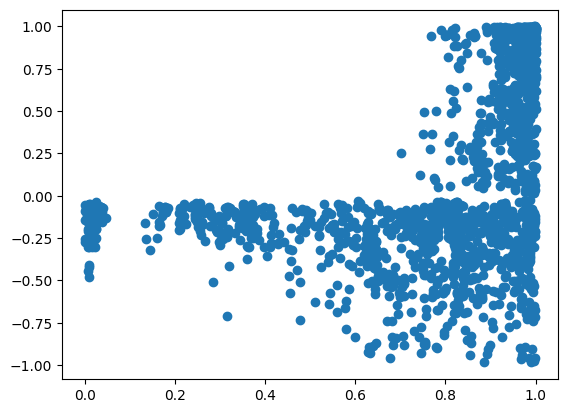

In [4]:
a = np.reshape(accuracy,-1)
q = np.reshape(quality,-1)
plt.scatter(q,a)

Text(0, 0.5, 'Accuracy')

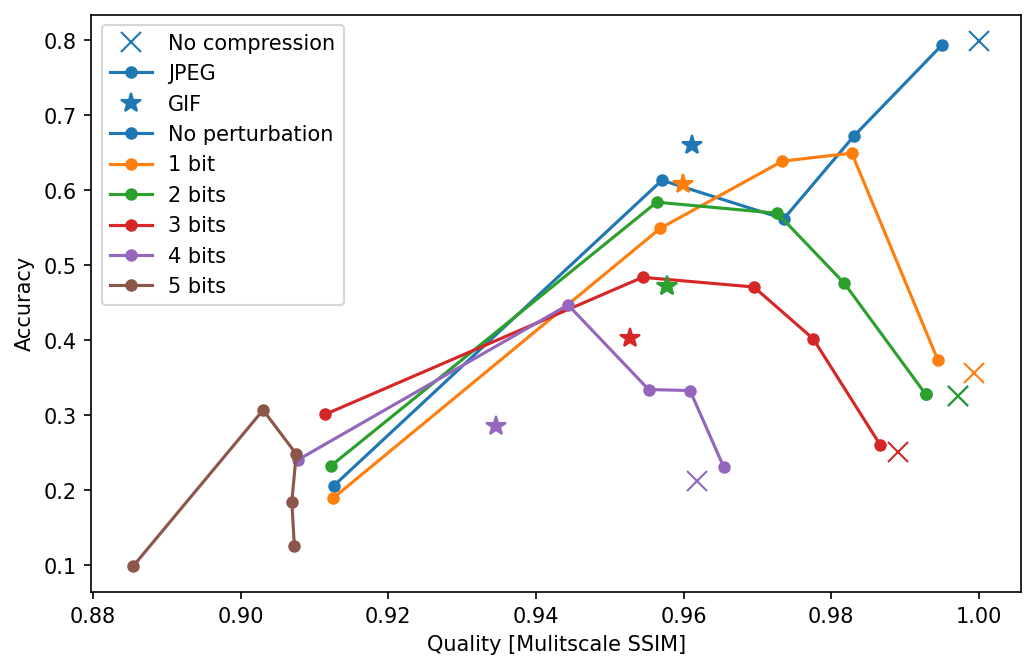

In [140]:
a = np.transpose(np.mean(accuracy[:,0:6,:],axis=0))
q = np.transpose(np.mean(quality[:,0:6,:],axis=0))

plt.figure(figsize=(8,5),dpi=150)
plt.plot(q[0,2],a[0,2],'x',markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(q[2,2],a[2,2],'.-',markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(q[1,2],a[1,2],'*',markersize=10)
plt.gca().set_prop_cycle(None)
plot1 = plt.plot(q[2:7,:],a[2:7,:],'.-',markersize=10);
plt.gca().set_prop_cycle(None)
for i_color in range(5):
    plot2 = plt.plot(q[0,i_color],a[0,i_color],'x',markersize=10)
plt.gca().set_prop_cycle(None)
for i_color in range(5):
    plot3 = plt.plot(q[1,i_color],a[1,i_color],'*',markersize=10)
# plt.legend(["No perturbation","1 bit","2 bits","3 bits","4 bits","5 bits"])

plt.legend(["No compression","JPEG","GIF","No perturbation","1 bit","2 bits","3 bits","4 bits","5 bits"])

plt.xlabel("Quality [Mulitscale SSIM]")
plt.ylabel("Accuracy")

#     a = np.mean(accuracy[:,p,1])
#     q = np.mean(quality[:,p,1],)
#     plt.plot(q,a,'r+',label='gif',markersize=10)

#     a = np.mean(accuracy[:,p,2:8],axis=0)
#     q = np.mean(quality[:,p,2:8],axis=0)
#     plt.plot(q,a,'-ko',label='jpeg')

#     plt.legend(loc='lower right')
#     plt.title("Attack "+str(p)+" least significant bits")
#     plt.xlabel('Structural Similarity')
#     plt.ylabel('Accuracy')

In [8]:
np.shape(accuracy)

(20, 10, 9)

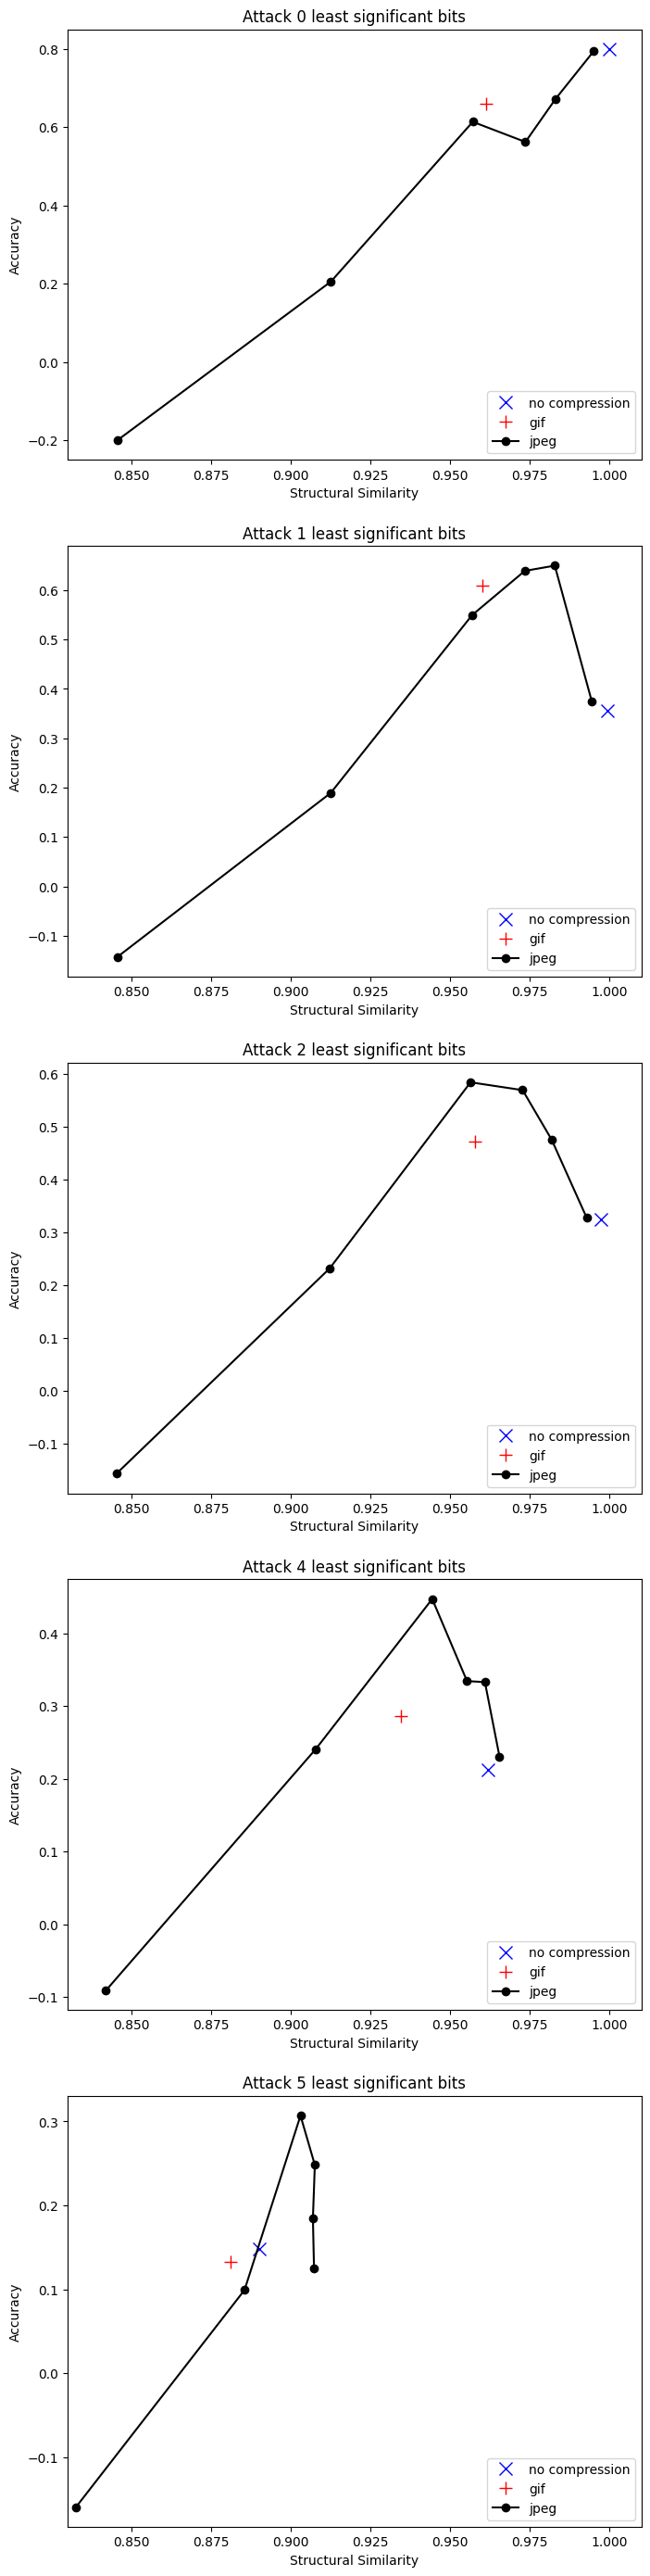

In [5]:
plt.figure(figsize=(8,35))
for ip, p in enumerate([0,1,2,4,5]):
    plt.subplot(5,1,ip+1)
    a = np.mean(accuracy[:,p,0])
    q = np.mean(quality[:,p,0])
    plt.plot(q,a,'bx',label='no compression',markersize=10)

    a = np.mean(accuracy[:,p,1])
    q = np.mean(quality[:,p,1],)
    plt.plot(q,a,'r+',label='gif',markersize=10)

    a = np.mean(accuracy[:,p,2:8],axis=0)
    q = np.mean(quality[:,p,2:8],axis=0)
    plt.plot(q,a,'-ko',label='jpeg')

    plt.legend(loc='lower right')
    plt.title("Attack "+str(p)+" least significant bits")
    plt.xlabel('Structural Similarity')
    plt.ylabel('Accuracy')
    plt.xlim([0.83,1.01])